In [ ]:
# 時系列に対する予測タスクでは、過去から学習と未来を予測するアプローチをとる
# つまり、ある特定の日まではすべてのデータを訓練セットとし、それ以降をテストセットとする
# 計算機で日時を格納するにはPOSIX時刻がよく用いられている

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
import mglearn

In [3]:
citibike = mglearn.datasets.load_citibike()
print(f"Citi Bike data:\n{citibike.head()}")

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


DatetimeIndex(['2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31'],
              dtype='datetime64[ns]', freq='D')


Text(0, 0.5, 'Rentals')

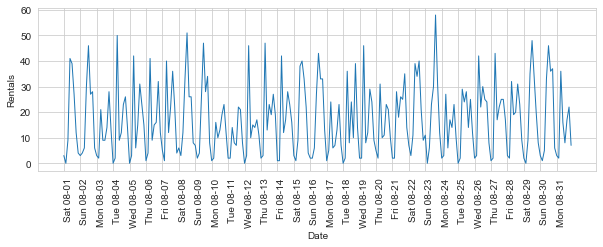

In [4]:
plt.figure(figsize = (10, 3))
xticks = pd.date_range(start = citibike.index.min(), end = citibike.index.max(), freq = "D")
print(xticks)
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation = 90, ha = "left")
plt.plot(citibike, linewidth = 1)
plt.xlabel("Date")
plt.ylabel("Rentals")

In [5]:
y = citibike.values
print(citibike.index.astype("int64"))
print(citibike.index.astype("int64").to_numpy())
print(citibike.index.astype("int64").to_numpy().reshape(-1, 1))
X = citibike.index.astype("int64").to_numpy().reshape(-1, 1) // 10 ** 9
print(X)

Int64Index([1438387200000000000, 1438398000000000000, 1438408800000000000,
            1438419600000000000, 1438430400000000000, 1438441200000000000,
            1438452000000000000, 1438462800000000000, 1438473600000000000,
            1438484400000000000,
            ...
            1440957600000000000, 1440968400000000000, 1440979200000000000,
            1440990000000000000, 1441000800000000000, 1441011600000000000,
            1441022400000000000, 1441033200000000000, 1441044000000000000,
            1441054800000000000],
           dtype='int64', name='starttime', length=248)
[1438387200000000000 1438398000000000000 1438408800000000000
 1438419600000000000 1438430400000000000 1438441200000000000
 1438452000000000000 1438462800000000000 1438473600000000000
 1438484400000000000 1438495200000000000 1438506000000000000
 1438516800000000000 1438527600000000000 1438538400000000000
 1438549200000000000 1438560000000000000 1438570800000000000
 1438581600000000000 1438592400000000000 1438

In [6]:
n_train = 184
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f"Test-set R^2: {regressor.score(X_test, y_test):.2f}")
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize = (10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation = 90, ha = "left")
    plt.plot(range(n_train), y_train, label = "train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label = "test" )
    plt.plot(range(n_train), y_pred_train, "--", label = "prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, "--", label = "prediction test")
    plt.legend(loc = (1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

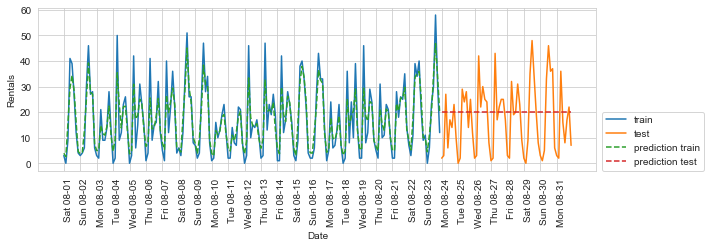

In [7]:
# テストセットのPOSIX秒のレンジは訓練セットのそれを外れており、決定木は訓練セットのレンジの外まで外挿することはできない
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
plt.figure()
eval_on_features(X, y, regressor)

Int64Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
            ...
            18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
           dtype='int64', name='starttime', length=248)
Test-set R^2: 0.60


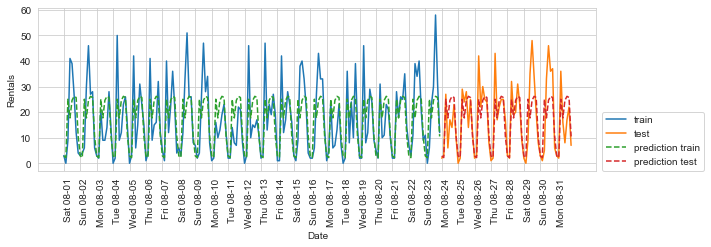

In [8]:
# POSIX秒だけを見ても何もわからないのでそれをなくし、時刻の要素を入れてみる
print(citibike.index.hour)
X_hour = citibike.index.hour.to_numpy().reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

Int64Index([5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
            ...
            6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name='starttime', length=248)
Test-set R^2: 0.84


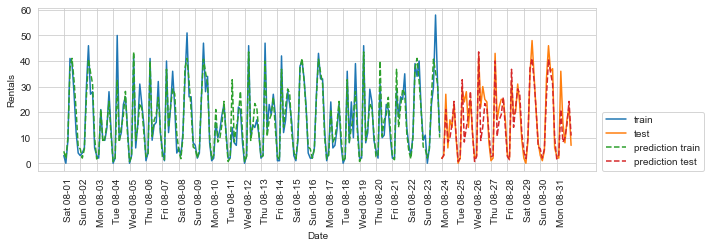

In [9]:
# 時刻と曜日の要素を入れてみる
print(citibike.index.dayofweek)
X_hour_week = np.hstack([citibike.index.dayofweek.to_numpy().reshape(-1, 1), citibike.index.hour.to_numpy().reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Test-set R^2: 0.13


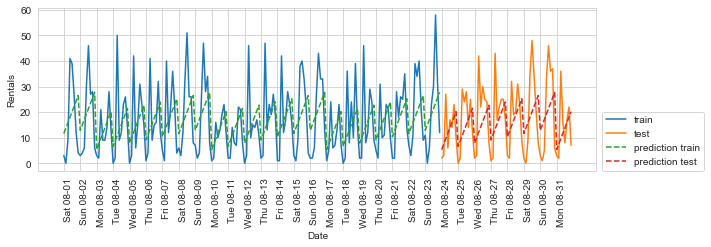

In [10]:
# 時刻と曜日が整数でエンコードされており、連続値として解釈されているため変な結果になっている
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

Test-set R^2: 0.62


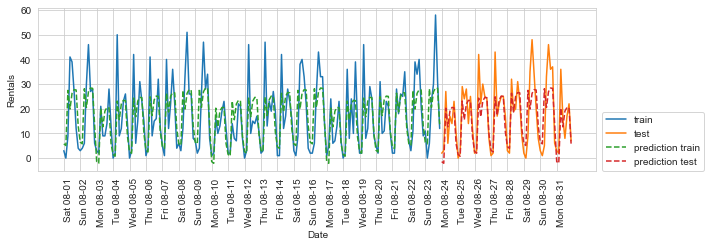

In [11]:
# 時刻と曜日の要則をカテゴリ変数として扱う（ダミー変数化）
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x5 x14', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x6 x14', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x7 x14', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x8 x14', 'x9 x10', 'x9 x11', 'x9 x12', 'x9 x13', 'x9 x14',

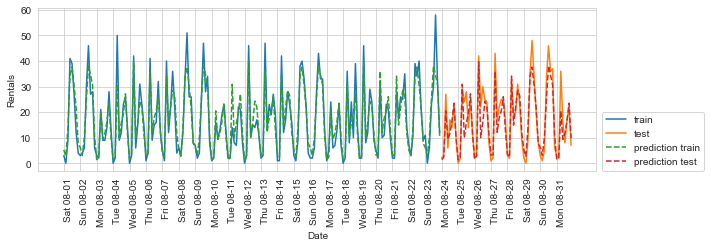

In [12]:
# 上記では時刻と曜日の影響が別々に出ていたので、時刻と曜日の組合せに対して係数を学習させるため、交互作用特徴量を考える
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
poly = poly_transformer.fit(X_hour_week_onehot)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
print(poly.get_feature_names())
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [13]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
print(hour)
day = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
features = day + hour
print(features)

['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']
['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


In [14]:
features_poly = poly_transformer.get_feature_names(features)
print(features_poly)
print(lr.coef_)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', 'Mon Tue', 'Mon Wed', 'Mon Thu', 'Mon Fri', 'Mon Sat', 'Mon Sun', 'Mon 00:00', 'Mon 03:00', 'Mon 06:00', 'Mon 09:00', 'Mon 12:00', 'Mon 15:00', 'Mon 18:00', 'Mon 21:00', 'Tue Wed', 'Tue Thu', 'Tue Fri', 'Tue Sat', 'Tue Sun', 'Tue 00:00', 'Tue 03:00', 'Tue 06:00', 'Tue 09:00', 'Tue 12:00', 'Tue 15:00', 'Tue 18:00', 'Tue 21:00', 'Wed Thu', 'Wed Fri', 'Wed Sat', 'Wed Sun', 'Wed 00:00', 'Wed 03:00', 'Wed 06:00', 'Wed 09:00', 'Wed 12:00', 'Wed 15:00', 'Wed 18:00', 'Wed 21:00', 'Thu Fri', 'Thu Sat', 'Thu Sun', 'Thu 00:00', 'Thu 03:00', 'Thu 06:00', 'Thu 09:00', 'Thu 12:00', 'Thu 15:00', 'Thu 18:00', 'Thu 21:00', 'Fri Sat', 'Fri Sun', 'Fri 00:00', 'Fri 03:00', 'Fri 06:00', 'Fri 09:00', 'Fri 12:00', 'Fri 15:00', 'Fri 18:00', 'Fri 21:00', 'Sat Sun', 'Sat 00:00', 'Sat 03:00', 'Sat 06:00', 'Sat 09:00', 'Sat 12:00', 'Sat 15:00', 'Sat 18:00', 'Sat 21:00', 'Sun 00:00', 'Sun 03:00

Text(0, 0.5, 'Feature magnitude')

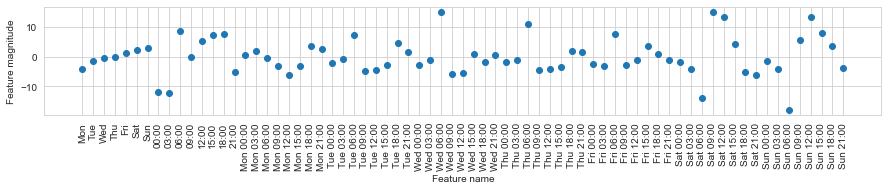

In [15]:
plt.figure(figsize = (15, 2))
plt.plot(coef_nonzero, "o")
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation = 90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")